# Descenso por coordenadas

In [25]:
install.packages("latex2exp",lib="/usr/local/lib/R/site-library/",
                repos="https://cran.itam.mx/")

In [1]:
options(repr.plot.width=6, repr.plot.height=6) #esta línea sólo se ejecuta para jupyterlab con R

In [2]:
library(ggplot2)
library(latex2exp)

In [3]:
inc_index<-function(vec,index,h){
    '
    Auxiliary function for gradient and Hessian computation.
    Args:
        vec (double): vector
        index (int): index.
        h (float):   quantity that vec[index] will be increased.
    Returns:
        vec (double): vector with vec[index] increased by h.
    '
    vec[index]<-vec[index]+h
    vec
}

In [4]:
gradient_approximation<-function(f,x,h=1e-8){
    '
    Numerical approximation of gradient for function f using forward differences.
    Args:
        f (expression): definition of function f.
        x (double): vector that holds values where gradient will be computed.
        h (float): step size for forward differences, tipically h=1e-8
    Returns:
        gf (array): numerical approximation to gradient of f.

    '
    n<-length(x)
    gf<-vector("double",n)
    for(i in 1:n){
        gf[i]=(f(inc_index(x,i,h))-f(x))
    }
    gf/h
}

In [5]:
Hessian_approximation<-function(f,x,h=1e-6){
    '
    Numerical approximation of Hessian for function f using forward differences.
    Args:
        f (expression): definition of function f.
        x (double): vector that holds values where Hessian will be computed.
        h (float): step size for forward differences, tipically h=1e-6
    Returns:
        Hf (double): matrix of numerical approximation to Hessian of f.
    '
    n<-length(x)
    Hf<-matrix(rep(0,n^2),nrow=n,ncol=n)
    f_x<-f(x)
    for(i in 1:n){
        x_inc_in_i<-inc_index(x,i,h)
        f_x_inc_in_i<-f(x_inc_in_i)
        for(j in i:n){
            dif<-f(inc_index(x_inc_in_i,j,h))-f_x_inc_in_i-f(inc_index(x,j,h))+f_x
            Hf[i,j]<-dif
            if(j!=i)
                Hf[j,i]<-dif
        }
    }
    Hf/h^2
}

In [6]:
line_search_by_backtracking<-function(f,dir_desc,x,
                                      der_direct, alpha=.15, beta=.5){
    '
    Line search that sufficiently decreases f restricted to a ray in the direction dir_desc.
    Args:
        alpha (float): parameter in line search with backtracking, tipically .15
        beta (float): parameter in line search with backtracking, tipically .5
        f (expression): definition of function f.
        dir_desc (double): vector of descent direction.
        x (double): vector that holds values where line search will be performed.
        der_direct (float): directional derivative of f.
    Returns:
        t (float): positive number for stepsize along dir_desc that sufficiently decreases f.
    '
    t<-1
    if (alpha > 1/2){
        print('alpha must be less than or equal to 1/2')
        t <- -1
    }
    if (beta>1){
        print('beta must be less than 1')
        t <- -1
    }
    if (t!=-1){
        eval1 <- f(x+t*dir_desc)
        eval2 <- f(x) + alpha*t*der_direct
        while (eval1 > eval2){
            t<-beta*t
            eval1 <- f(x+t*dir_desc)
            eval2 <- f(x)+alpha*t*der_direct
        }
    }else
        t <- -1
    t
}

In [7]:
Euclidian_norm<-function(vec){
    sqrt(sum(vec*vec))
}

In [8]:
compute_error<-function(x_obj,x_approx){
    '
    Relative error between x_obj and x_approx.
    '
    if (Euclidian_norm(x_obj) > .Machine$double.eps){
        Err<-Euclidian_norm(x_obj-x_approx)/Euclidian_norm(x_obj)
    }else
        Err<-Euclidian_norm(x_obj-x_approx)
    Err
}

In [9]:
gradient_descent<-function(f, x_0, tol, 
                        tol_backtracking, x_ast, p_ast, maxiter){
    '
    Method of gradient descent to numerically approximate solution of min f.
    Args:
        f (expression): definition of function f.
        x_0 (double): vector of initial point for gradient descent method.
        tol (float): tolerance that will halt method. Controls norm of gradient of f.
        tol_backtracking (float): tolerance that will halt method. Controls value of line search by backtracking.
        x_ast (double): vector solution of min f, now its required that user knows the solution...
        p_ast (double): vector value of f(x_ast), now its required that user knows the solution...
        maxiter (int): maximum number of iterations
    Returns:
        x (double): vector approximation of x_ast.
        iteration (int): number of iterations.
        Err_plot (double): vector array of absolute error between p_ast and f(x) with x approximation.
                          of x_ast. Useful for plotting.
        x_plot (double): vector array that containts in columns vector of approximations. Last column
                        contains x, approximation of solution. Useful for plotting.
    '
    iteration <- 1
    x <- x_0
    
    feval <- f(x)
    gfeval <- gradient_approximation(f,x)

    normgf <- Euclidian_norm(gfeval)
    
    Err_plot_aux <- vector("double",maxiter)
    Err_plot_aux[iteration] <- abs(feval-p_ast)
    
    Err <- compute_error(x_ast,x)
    n <- length(x)
    x_plot <- matrix(0,nrow=n,ncol=maxiter)
    x_plot[,iteration] <- x
    
    cat(sprintf("I    Normagf   Error x_ast   Error p_ast   line search\n"))
    cat(sprintf("%d    %.2e   %0.2e      %0.2e      %s\n",iteration,normgf,Err,Err_plot_aux[iteration],"---"))
    iteration<-iteration + 1
    while(normgf>tol && iteration <= maxiter){
        dir_desc <- -gfeval
        der_direct <- sum(gfeval*dir_desc)
        t <- line_search_by_backtracking(f,dir_desc,x,der_direct)
        x <- x + t*dir_desc
        feval <- f(x)
        gfeval <- gradient_approximation(f,x)
        normgf <- Euclidian_norm(gfeval)
        Err_plot_aux[iteration] <- abs(feval-p_ast);
        x_plot[,iteration] <- x
        Err <- compute_error(x_ast,x)
        cat(sprintf("%d    %.2e   %0.2e      %0.2e      %s\n",iteration,normgf,Err,Err_plot_aux[iteration],t))
        if (t<tol_backtracking){ #if t is less than tol_backtracking then we need to check the reason
            iter_salida <- iteration
            iteration <- maxiter
        }
        iteration <- iteration + 1
    } #while
    cat(sprintf("Error of x with respect to x_ast: %.2e\n",Err))
    cat(sprintf("Approximate solution:"))
    print(x)
    cond <- Err_plot_aux > .Machine$double.eps*10**(-2)
    Err_plot = Err_plot_aux[cond]
    cond<- apply(x_plot,2,function(x) all(x==0))
    x_plot <- x_plot[,!cond]
    if (iteration == maxiter && t < tol_backtracking){
        print("Backtracking value less than tol_backtracking, check approximation")
        iteration<-iter_salida
    }
   list(x,iteration-1,Err_plot,x_plot)
    
}    

In [10]:
fo <-function(x)(x[1]-2)**2 + (2-x[2])**2 + x[3]**2 + x[4]**4


In [11]:
x_ast <- c(2,2,0,0)
x_0 <- c(5,5,1,0)
tol <- 1e-8
tol_backtracking <- 1e-14
maxiter <- 5
p_ast <- fo(x_ast)


In [12]:
l<-gradient_descent(fo, x_0, tol, tol_backtracking, x_ast, p_ast, maxiter)

I    Normagf   Error x_ast   Error p_ast   line search
1    8.72e+00   1.54e+00      1.90e+01      ---
2    3.53e-07   6.10e-08      2.98e-14      0.5
3    2.20e-15   3.06e-09      7.50e-17      0.5
Error of x with respect to x_ast: 3.06e-09
Approximate solution:[1]  2e+00  2e+00 -5e-09  0e+00


In [13]:
x <- l[[1]]
total_of_iterations <- l[[2]]
Err_plot <- l[[3]]
x_plot <- l[[4]]


In [14]:
gg <- ggplot()

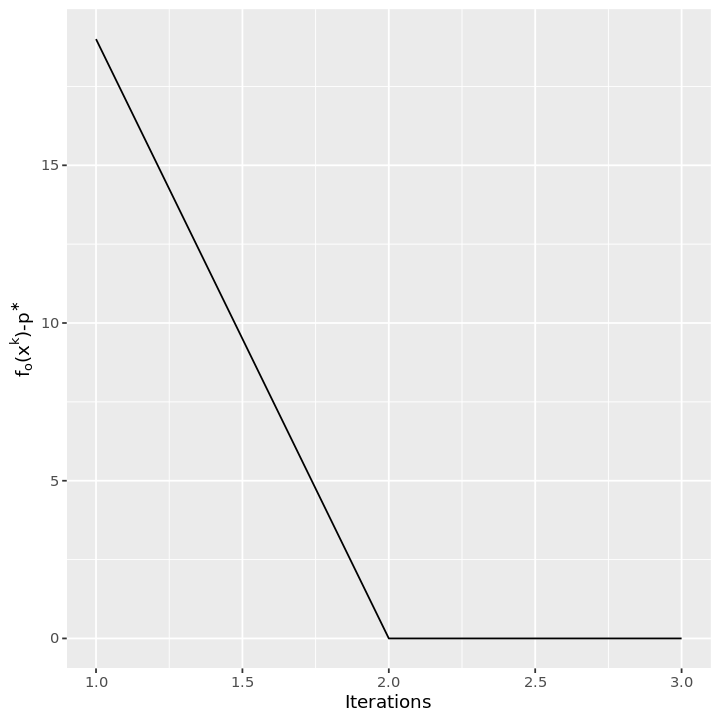

In [15]:
gg +
geom_line(aes(x=1:total_of_iterations,y=Err_plot)) + 
xlab('Iterations') + ylab(TeX('f_o(x^k)-p^*'))

Ejemplo 2

In [16]:
cte<-10

In [17]:
fo <- function(x) 1/2*(x[1]**2+cte*x[2]**2)

In [18]:
x_ast <- c(0,0)
x_0 <- c(0.5,0.5)
tol <- 1e-8
tol_backtracking <- 1e-14
maxiter <- 50
p_ast <- fo(x_ast)
l<-gradient_descent(fo, x_0, tol, tol_backtracking, x_ast, p_ast, maxiter)
x <- l[[1]]
total_of_iterations <- l[[2]]
Err_plot <- l[[3]]
x_plot <- l[[4]]


I    Normagf   Error x_ast   Error p_ast   line search
1    5.02e+00   7.07e-01      1.38e+00      ---
2    1.32e+00   4.55e-01      1.74e-01      0.125
3    4.94e-01   3.84e-01      7.82e-02      0.125
4    5.50e-01   2.91e-01      5.22e-02      0.25
5    2.77e-01   2.51e-01      3.22e-02      0.125
6    4.85e-01   1.34e-01      1.89e-02      0.5
7    1.61e-01   1.11e-01      6.73e-03      0.125
8    1.94e-01   8.43e-02      4.94e-03      0.25
9    8.45e-02   7.23e-02      2.70e-03      0.125
10    8.53e-02   5.45e-02      1.68e-03      0.25
11    1.07e-01   4.18e-02      1.31e-03      0.25
12    4.33e-02   3.56e-02      6.61e-04      0.125
13    4.56e-02   2.69e-02      4.23e-04      0.25
14    2.51e-02   2.33e-02      2.76e-04      0.125
15    3.89e-02   1.22e-02      1.37e-04      0.5
16    1.38e-02   1.02e-02      5.62e-05      0.125
17    1.59e-02   7.77e-03      3.89e-05      0.25
18    7.54e-03   6.70e-03      2.30e-05      0.125
19    1.43e-02   3.62e-03      1.53e-05      0.5

In [19]:
gg <- ggplot()

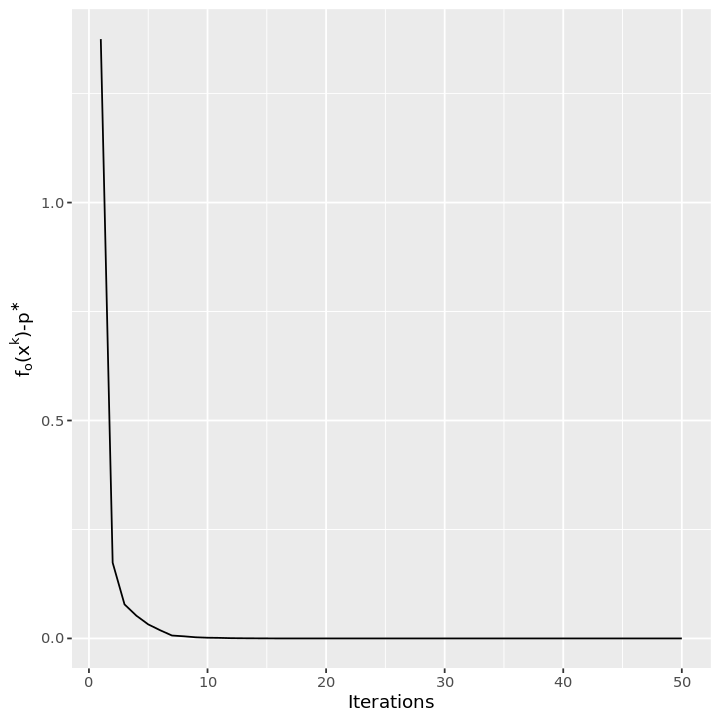

In [20]:
gg +
geom_line(aes(x=1:total_of_iterations,y=Err_plot)) + 
xlab('Iterations') + ylab(TeX('f_o(x^k)-p^*'))

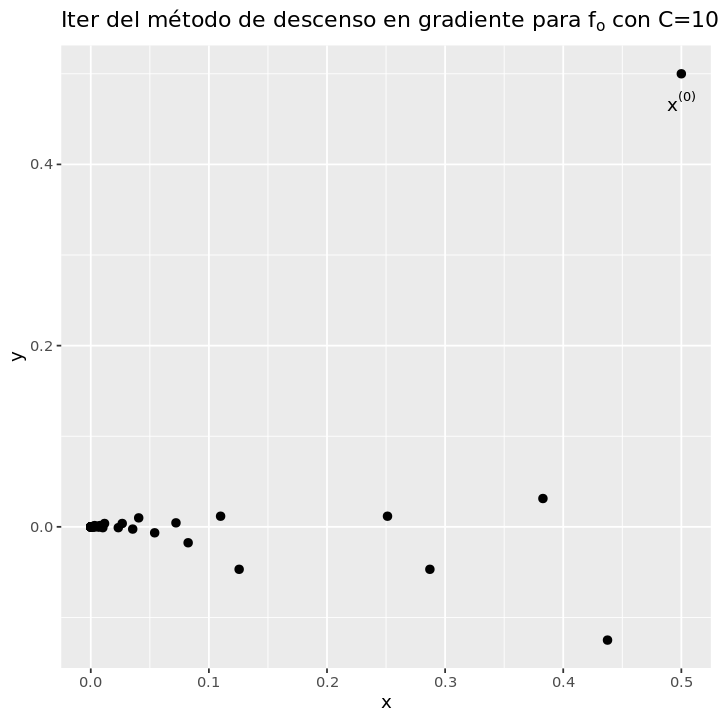

In [21]:
gg +
geom_point(aes(x=x_plot[1,],y=x_plot[2,]),size=2) +
annotate(geom='text', x=0.5, y=0.47, 
         label=TeX("x^{(0)}", output='character'), parse=TRUE) + 
xlab('x') + ylab('y') + 
ggtitle(TeX('Iter del método de descenso en gradiente para $f_o$ con $C=10$'))

**Coordinate descent**

In [22]:
coordinate_descent<-function(f, x_0, tol, 
                        tol_backtracking, x_ast, p_ast, maxiter){
    '
    Method of gradient descent to numerically approximate solution of min f.
    Args:
        f (expression): definition of function f.
        x_0 (double): vector of initial point for gradient descent method.
        tol (float): tolerance that will halt method. Controls norm of gradient of f.
        tol_backtracking (float): tolerance that will halt method. Controls value of line search by backtracking.
        x_ast (double): vector solution of min f, now its required that user knows the solution...
        p_ast (double): vector value of f(x_ast), now its required that user knows the solution...
        maxiter (int): maximum number of iterations
    Returns:
        x (double): vector approximation of x_ast.
        iteration (int): number of iterations.
        Err_plot (double): vector array of absolute error between p_ast and f(x) with x approximation.
                          of x_ast. Useful for plotting.
        x_plot (double): vector array that containts in columns vector of approximations. Last column
                        contains x, approximation of solution. Useful for plotting.
    '
    iteration <- 1
    x <- x_0
    
    feval <- f(x)
    gfeval <- gradient_approximation(f,x)

    normgf <- Euclidian_norm(gfeval)
    
    Err_plot_aux <- vector("double",maxiter)
    Err_plot_aux[iteration] <- abs(feval-p_ast)
    
    Err <- compute_error(x_ast,x)
    n <- length(x)
    x_plot <- matrix(0,nrow=n,ncol=maxiter)
    x_plot[,iteration] <- x
    
    cat(sprintf("I    Normagf   Error x_ast   Error p_ast   line search\n"))
    cat(sprintf("%d    %.2e   %0.2e      %0.2e      %s\n",iteration,normgf,Err,Err_plot_aux[iteration],"---"))
    iteration<-iteration + 1
    while(normgf>tol && iteration <= maxiter){
        ind_maximo <- which.max(abs(gfeval))
        e_canonico <- vector("integer",n)
        e_canonico[ind_maximo] <- 1
        dir_desc <- -gfeval[ind_maximo]*e_canonico
        der_direct <- sum(gfeval*dir_desc)
        t <- line_search_by_backtracking(f,dir_desc,x,der_direct)
        x <- x + t*dir_desc
        feval <- f(x)
        gfeval <- gradient_approximation(f,x)
        normgf <- Euclidian_norm(gfeval)
        Err_plot_aux[iteration] <- abs(feval-p_ast);
        x_plot[,iteration] <- x
        Err <- compute_error(x_ast,x)
        cat(sprintf("%d    %.2e   %0.2e      %0.2e      %s\n",iteration,normgf,Err,Err_plot_aux[iteration],t))
        if (t<tol_backtracking){ #if t is less than tol_backtracking then we need to check the reason
            iter_salida <- iteration
            iteration <- maxiter
        }
        iteration <- iteration + 1
    } #while
    cat(sprintf("Error of x with respect to x_ast: %.2e\n",Err))
    cat(sprintf("Approximate solution:"))
    print(x)
    cond <- Err_plot_aux > .Machine$double.eps*10**(-2)
    Err_plot = Err_plot_aux[cond]
    cond<- apply(x_plot,2,function(x) all(x==0))
    x_plot <- x_plot[,!cond]
    if (iteration == maxiter && t < tol_backtracking){
        print("Backtracking value less than tol_backtracking, check approximation")
        iteration<-iter_salida
    }
   list(x,iteration-1,Err_plot,x_plot)
    
}    

In [23]:
fo <-function(x)(x[1]-2)**2 + (2-x[2])**2 + x[3]**2 + x[4]**4


In [24]:
x_ast <- c(2,2,0,0)
x_0 <- c(5,5,1,0)
tol <- 1e-8
tol_backtracking <- 1e-14
maxiter <- 5
p_ast <- fo(x_ast)


In [25]:
l<-coordinate_descent(fo, x_0, tol, tol_backtracking, x_ast, p_ast, maxiter)

I    Normagf   Error x_ast   Error p_ast   line search
1    8.72e+00   1.54e+00      1.90e+01      ---
2    6.32e+00   1.12e+00      1.00e+01      0.5
3    2.00e+00   3.54e-01      1.00e+00      0.5
4    2.30e-07   3.85e-08      1.18e-14      0.5
5    5.15e-08   7.02e-09      3.94e-16      0.5
Error of x with respect to x_ast: 7.02e-09
Approximate solution:[1] 2.000000e+00 2.000000e+00 6.077471e-09 0.000000e+00


In [26]:
x <- l[[1]]
total_of_iterations <- l[[2]]
Err_plot <- l[[3]]
x_plot <- l[[4]]


In [27]:
gg <- ggplot()

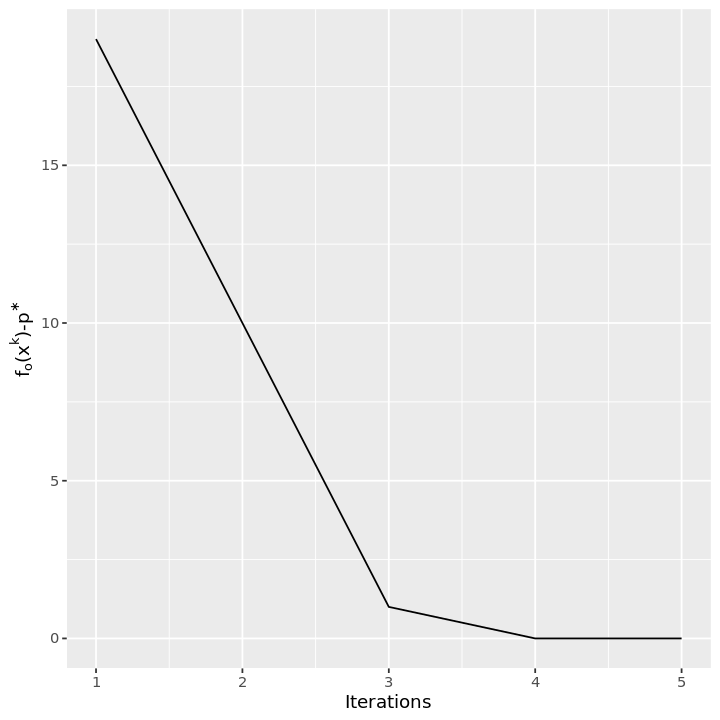

In [28]:
gg +
geom_line(aes(x=1:total_of_iterations,y=Err_plot)) + 
xlab('Iterations') + ylab(TeX('f_o(x^k)-p^*'))

Ejemplo 2

In [29]:
cte<-10

In [30]:
fo <- function(x) 1/2*(x[1]**2+cte*x[2]**2)

In [31]:
x_ast <- c(0,0)
x_0 <- c(0.5,0.5)
tol <- 1e-7
tol_backtracking <- 1e-14
maxiter <- 50
p_ast <- fo(x_ast)
l<-coordinate_descent(fo, x_0, tol, tol_backtracking, x_ast, p_ast, maxiter)
x <- l[[1]]
total_of_iterations <- l[[2]]
Err_plot <- l[[3]]
x_plot <- l[[4]]


I    Normagf   Error x_ast   Error p_ast   line search
1    5.02e+00   7.07e-01      1.38e+00      ---
2    1.35e+00   5.15e-01      2.03e-01      0.125
3    5.90e-01   5.01e-01      1.30e-01      0.125
4    3.13e-01   3.12e-02      4.88e-03      1
5    7.81e-02   7.81e-03      3.05e-04      0.125
6    1.95e-02   1.95e-03      1.91e-05      0.125
7    4.88e-03   4.88e-04      1.19e-06      0.125
8    1.22e-03   1.22e-04      7.45e-08      0.125
9    3.05e-04   3.05e-05      4.66e-09      0.125
10    7.63e-05   7.62e-06      2.91e-10      0.125
11    1.91e-05   1.91e-06      1.83e-11      0.125
12    4.77e-06   4.72e-07      1.11e-12      0.125
13    1.19e-06   1.24e-07      7.72e-14      0.125
14    2.98e-07   2.61e-08      3.11e-15      0.125
15    7.46e-08   1.48e-08      8.08e-16      0.125
Error of x with respect to x_ast: 1.48e-08
Approximate solution:[1] -8.063495e-09 -1.245058e-08


In [32]:
total_of_iterations

[1] 15

In [33]:
gg <- ggplot()

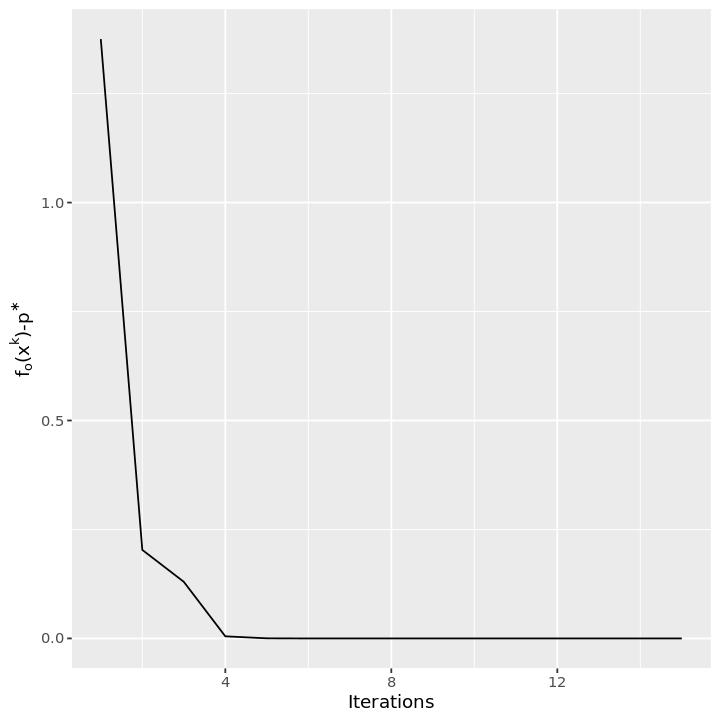

In [34]:
gg +
geom_line(aes(x=1:total_of_iterations,y=Err_plot)) + 
xlab('Iterations') + ylab(TeX('f_o(x^k)-p^*'))

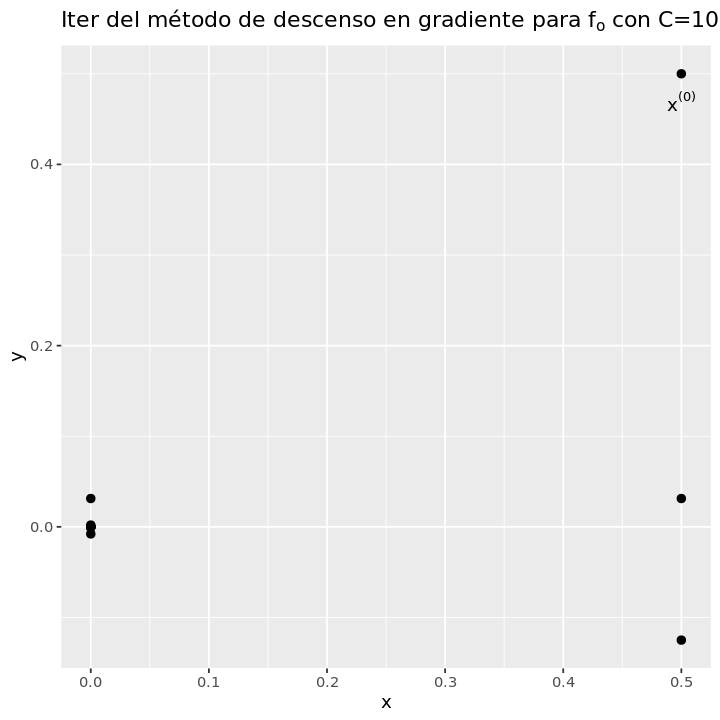

In [35]:
gg +
geom_point(aes(x=x_plot[1,],y=x_plot[2,]),size=2) +
annotate(geom='text', x=0.5, y=0.47, 
         label=TeX("x^{(0)}", output='character'), parse=TRUE) + 
xlab('x') + ylab('y') + 
ggtitle(TeX('Iter del método de descenso en gradiente para $f_o$ con $C=10$'))

In [36]:
x_plot

0.5,0.500,0.50000,-8.063495e-09,-8.063495e-09,-8.063495e-09,-8.063495e-09,-8.063495e-09,-8.063495e-09,-8.063495e-09,-8.063495e-09,-8.063495e-09,-8.063495e-09,-8.063495e-09,-8.063495e-09
0.5,-0.125,0.03125,3.125000e-02,-7.812505e-03,1.953120e-03,-4.882863e-04,1.220653e-04,-3.052258e-05,7.624395e-06,-1.912349e-06,4.718372e-07,-1.242093e-07,2.480232e-08,-1.245058e-08
